In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()

In [2]:
client = bigquery.Client()

query="""
SELECT DATE, GDP from goldenfleece.final_task.monthly_gdp_lag order by DATE
"""
gdp_df = client.query(query).to_dataframe()
gdp_df.head()

,DATE,GDP
0,1997-06-01,0.8
1,1997-07-01,0.1
2,1997-08-01,0.4
3,1997-09-01,0.5
4,1997-10-01,0.8


In [3]:
gdp_df = gdp_df.astype({"DATE":"datetime64"})
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    280 non-null    datetime64[ns]
 1   GDP     280 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.5 KB


In [4]:
from cross_validate import cross_validate, build_design_matrix

In [5]:
design_df = build_design_matrix(gdp_df, "DATE", "GDP", horizon=1, start_date="2015-03-01", end_date="2020-01-01")
design_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        59 non-null     datetime64[ns]
 1   target_lag  59 non-null     float64       
 2   target      59 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


In [6]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()

rmse_list = []
for horizon in [3,6,9]:
    result_df = cross_validate(
        design_df,
        lr,
        initial=36,
        period=1,
        horizon=horizon,
        date_col="DATE",
        feature_cols=["target_lag"],
        target_col="target",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 20 predictions for 3-month horizon: 0.248
Average RMSE over 17 predictions for 6-month horizon: 0.243
Average RMSE over 14 predictions for 9-month horizon: 0.267

Average RMSE across different horizons: 0.252


<AxesSubplot:xlabel='date'>

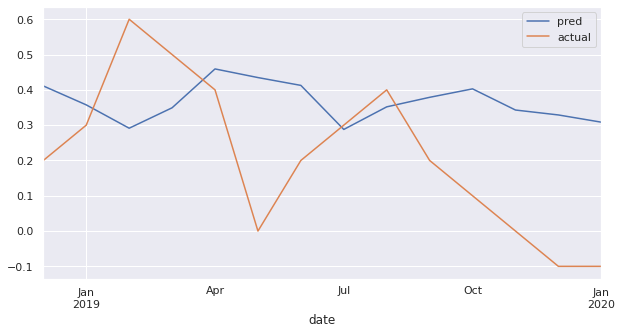

In [7]:
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5))